In [ ]:
import numpy as np
import random
import math

# Data masalah
locations = [
    "Depot", "Marina Raya", "Marina Karimun", "Tlogosari", "Dempel Raya",
    "Muktiharjo Kidul", "Anjasmoro", "Krobokan", "Tanah Mas", "Semarang Indah",
    "Muara Mas", "Tambak Mas", "Tambak Mas 2", "Shelter"
]

distances = [
    [0, 9.7, 10.1, 16.4, 15.1, 15.2, 15.8, 7.9, 8.5, 11.9, 9.1, 11, 10.7, 10.6],
    [9.1, 0, 1.5, 11.7, 10.5, 10.6, 10.9, 3.3, 4.1, 4, 3.2, 3.2, 3.2, 6.3],
    [9.9, 0.8, 0, 12.1, 10.9, 11, 10.7, 3, 3.8, 3.8, 2.7, 2.9, 2.9, 7.1],
    [15.5, 13.7, 13.3, 0, 2.3, 2.2, 2.6, 9.9, 9.2, 8.7, 9.7, 10.8, 9.9, 6.4],
    [15.5, 12.7, 12.3, 2.9, 0, 0.2, 0.2, 11.9, 9.7, 7.7, 9.8, 10.1, 9.8, 6.2],
    [15.6, 12.7, 12.3, 2.5, 0.2, 0, 0.2, 12.5, 9.3, 8.1, 10.2, 9.8, 10.2, 6.3],
    [16.5, 11.5, 12.1, 2.6, 0.2, 0.2, 0, 9.5, 8.5, 7.2, 9.6, 8, 9.6, 5.7],
    [7.2, 3.8, 3.4, 10.6, 9.4, 9.5, 10.1, 0, 1.3, 5.2, 2.7, 4.3, 5, 4.9],
    [9, 4.5, 4.1, 9.7, 8.5, 9, 9.2, 1.3, 0, 4.3, 1.2, 5, 4.1, 4],
    [11.9, 5.7, 5.3, 8.4, 7.1, 7.5, 7.8, 5, 4.7, 0, 4.6, 1.1, 1, 4.4],
    [9.7, 3.2, 2.9, 10.8, 9.5, 9.6, 10.3, 2.7, 1.7, 4.6, 0, 3.8, 3.8, 5],
    [11, 4.8, 4.4, 9.2, 7.9, 8, 9.8, 4.1, 4.9, 1.1, 3.7, 0, 0.3, 5.2],
    [11, 4.8, 4.5, 8.7, 7.5, 7.8, 7.8, 4.1, 4.9, 1, 3.8, 0.3, 0, 5.8],
    [10.5, 7.2, 7.6, 6, 6.9, 7, 7.1, 4.9, 4.2, 4.8, 4.8, 5.6, 5.4, 0]
]

class HybridAntFireworksOptimization:
    def __init__(self, problem_params):
        # Problem Parameters
        self.problem_size = problem_params['problem_size']
        self.num_vehicles = problem_params['num_vehicles']
        self.vehicle_capacity = problem_params['vehicle_capacity']
        self.demands = problem_params['demands']
        self.depot = problem_params['depot']
        self.shelter = problem_params['shelter']
        self.locations = problem_params['locations']

        # ACO Parameters
        self.num_ants = problem_params['num_ants']
        self.max_iterations = problem_params['max_iterations']
        self.alpha = problem_params['alpha']
        self.beta = problem_params['beta']
        self.evaporation_rate = problem_params['evaporation_rate']

        # Fireworks Parameters
        self.A_cap = problem_params['A_cap']
        self.M = problem_params['M']
        self.a = problem_params['a']
        self.b = problem_params['b']

        # Pheromone Parameters
        self.Q = problem_params['Q']
        self.tau_min = problem_params['tau_min']
        self.tau_max = problem_params['tau_max']

        # Initialize matrices
        self.y = np.zeros((self.problem_size, self.num_vehicles))
        self.x = np.zeros((self.problem_size, self.problem_size, self.num_vehicles))
        self.q = np.zeros((self.problem_size, self.num_vehicles))

        # Initialize data structures
        self.pheromone_matrix = None
        self.distance_matrix = None
        self.best_solution = None
        self.best_fitness = float('inf')
        self.iteration_history = []

    def initialize_problem(self, distance_matrix):
        """Initialize problem-specific components"""
        self.distance_matrix = distance_matrix
        self.pheromone_matrix = np.ones_like(distance_matrix) * self.tau_min
        self.population = self.generate_initial_population()

    def generate_initial_population(self):
        """Generate initial population of solutions"""
        population = []
        for _ in range(self.num_ants):
            # Generate random solution
            solution = list(range(1, self.problem_size-1))  # Exclude depot and shelter
            random.shuffle(solution)
            # Add depot at start and shelter at end
            solution = [self.depot] + solution + [self.shelter]
            population.append(solution)
        return population

    def is_route_feasible(self, route):
        """Check if route satisfies all constraints"""
        if not route:
            return False

        # Check if route starts from depot and ends at shelter
        if route[0] != self.depot or route[-1] != self.shelter:
            return False

        # Check capacity constraint
        total_demand = sum(self.demands[i] for i in route[1:-1])  # Exclude depot and shelter
        if total_demand > self.vehicle_capacity:
            return False

        # Check if all locations in route are unique (except depot/shelter)
        visited = set(route[1:-1])
        if len(visited) != len(route[1:-1]):
            return False

        return True

    def calculate_route_fitness(self, route):
        """Calculate fitness (total distance) for a single route"""
        if not route or len(route) < 2:
            return float('inf')

        total_distance = 0
        for i in range(len(route) - 1):
            total_distance += self.distance_matrix[route[i]][route[i+1]]

        # Add distance back to depot from shelter
        total_distance += self.distance_matrix[self.shelter][self.depot]

        return total_distance

    def calculate_fitness(self, solution):
        """Calculate solution fitness considering multiple vehicles"""
        routes = self.split_into_vehicle_routes(solution)
        if routes is None:
            return float('inf')

        total_fitness = 0
        visited_locations = set()

        for route in routes:
            # Check route feasibility
            if not self.is_route_feasible(route):
                return float('inf')

            # Add locations to visited set (excluding depot and shelter)
            visited_locations.update(route[1:-1])

            # Add route distance
            total_fitness += self.calculate_route_fitness(route)

        # Check if all locations are visited exactly once
        required_locations = set(range(1, self.problem_size-1))  # Exclude depot and shelter
        if visited_locations != required_locations:
            return float('inf')

        return total_fitness

    def split_into_vehicle_routes(self, solution):
        """Split a complete solution into feasible vehicle routes"""
        if not solution:
            return None

        routes = []
        current_route = [self.depot]
        current_load = 0

        for node in solution[1:]:  # Skip first node (depot)
            if node == self.shelter:  # End of route
                if len(current_route) > 1:  # Only add route if it contains customers
                    current_route.append(self.shelter)
                    routes.append(current_route)
                    current_route = [self.depot]
                    current_load = 0
                continue

            # Check if adding this node exceeds vehicle capacity
            if current_load + self.demands[node] <= self.vehicle_capacity:
                current_route.append(node)
                current_load += self.demands[node]
            else:
                # Finish current route
                if len(current_route) > 1:
                    current_route.append(self.shelter)
                    routes.append(current_route)

                # Start new route
                if len(routes) < self.num_vehicles:
                    current_route = [self.depot, node]
                    current_load = self.demands[node]
                else:
                    return None  # Cannot create feasible routes

        # Add final route if not empty
        if len(current_route) > 1:
            current_route.append(self.shelter)
            routes.append(current_route)

        # Check if we have a valid number of routes
        if len(routes) > self.num_vehicles:
            return None

        # Verify all routes visit shelter
        for route in routes:
            if route[-1] != self.shelter:
                route.append(self.shelter)

        return routes

    def update_solution_matrices(self, routes):
        """Update CVRP solution matrices (x, y, q)"""
        # Reset matrices
        self.y.fill(0)
        self.x.fill(0)
        self.q.fill(0)

        # Update matrices for each vehicle route
        for k, route in enumerate(routes):
            current_load = 0
            for i in range(len(route) - 1):
                current = route[i]
                next_node = route[i + 1]

                # Update x (route) matrix
                self.x[current, next_node, k] = 1

                # Update y (visit) matrix
                self.y[current, k] = 1

                # Update q (load) matrix
                if current != self.depot and current != self.shelter:
                    current_load += self.demands[current]
                self.q[current, k] = current_load

            # Add return to depot after shelter
            if route[-1] == self.shelter:
                self.x[self.shelter, self.depot, k] = 1

    def transition_probability(self, current_node, unvisited, current_load=0):
        """Calculate transition probabilities considering capacity constraints"""
        probabilities = []
        total = 0

        for node in unvisited:
            # Skip if adding node would exceed capacity
            if current_load + self.demands[node] > self.vehicle_capacity:
                continue

            # Calculate probability based on pheromone and distance
            pheromone = self.pheromone_matrix[current_node][node] ** self.alpha
            distance = (1.0 / (self.distance_matrix[current_node][node] + 1e-10)) ** self.beta
            probability = pheromone * distance

            probabilities.append((node, probability))
            total += probability

        # If no feasible nodes found, force return to shelter
        if not probabilities:
            return [(self.shelter, 1.0)]

        # Normalize probabilities
        return [(node, prob/total) for node, prob in probabilities]

    def probabilistic_selection(self, probabilities):
        """Select next node based on probabilities"""
        r = random.random()
        cumulative = 0
        for node, prob in probabilities:
            cumulative += prob
            if r <= cumulative:
                return node
        return probabilities[-1][0] if probabilities else self.shelter

    def construct_ant_solutions(self):
        """Construct solutions for each ant considering vehicle constraints"""
        solutions = []

        for _ in range(self.num_ants):
            all_routes = []
            unvisited = set(range(1, self.problem_size-1))  # Exclude depot and shelter

            while unvisited and len(all_routes) < self.num_vehicles:
                route = [self.depot]
                current_node = self.depot
                current_load = 0
                route_unvisited = unvisited.copy()

                while route_unvisited:
                    # Calculate probabilities for next node
                    probabilities = self.transition_probability(
                        current_node, route_unvisited, current_load)

                    # Select next node
                    next_node = self.probabilistic_selection(probabilities)

                    if next_node == self.shelter:
                        break

                    route.append(next_node)
                    current_node = next_node
                    current_load += self.demands[next_node]
                    unvisited.remove(next_node)
                    route_unvisited.remove(next_node)

                # Add shelter to end of route
                route.append(self.shelter)

                if len(route) > 2:  # Only add route if it contains customers
                    all_routes.append(route)

            # Create complete solution
            if len(all_routes) > 0:
                complete_solution = [self.depot]
                for route in all_routes:
                    complete_solution.extend(route[1:])  # Skip depot from each route
                solutions.append(complete_solution)

        return solutions

    def generate_fireworks_sparks(self, solutions):
        """Generate sparks using Fireworks Algorithm for CVRP"""
        if not solutions:
            return []

        # Calculate fitness values
        fitness_values = [self.calculate_fitness(sol) for sol in solutions]
        max_fitness = max(fitness_values)
        min_fitness = min(fitness_values)

        # Calculate spark counts
        spark_counts = []
        total_sparks = self.M

        if max_fitness == min_fitness:
            # Equal distribution if all solutions have same fitness
            base_sparks = total_sparks // len(solutions)
            spark_counts = [base_sparks] * len(solutions)
        else:
            for fitness in fitness_values:
                # Calculate normalized spark count
                spark_count = total_sparks * (max_fitness - fitness) / \
                            (sum(max_fitness - f for f in fitness_values) + 1e-10)
                spark_counts.append(spark_count)

        # Limit spark counts
        limited_sparks = self.limit_sparks(spark_counts)

        # Generate sparks
        all_sparks = []
        for sol, num_sparks in zip(solutions, limited_sparks):
            routes = self.split_into_vehicle_routes(sol)
            if routes:
                for _ in range(int(num_sparks)):
                    spark = self.cvrp_mutation(routes, 0.5)  # Fixed amplitude
                    if spark:
                        flat_spark = [self.depot]
                        for route in spark[:-1]:
                            flat_spark.extend(route[1:-1])
                        flat_spark.extend(spark[-1][1:])
                        all_sparks.append(flat_spark)

        return all_sparks

    def calculate_explosion_amplitude(self, fitness_values):
        """Calculate explosion amplitudes for fireworks"""
        if not fitness_values:
            return []

        min_fitness = min(fitness_values)
        max_fitness = max(fitness_values)

        if max_fitness == min_fitness:
            return [self.A_cap / len(fitness_values)] * len(fitness_values)

        amplitudes = []
        for fitness in fitness_values:
            amplitude = self.A_cap * (max_fitness - fitness) / \
                       (max_fitness - min_fitness + 1e-10)
            amplitudes.append(max(0.1, min(amplitude, self.A_cap)))

        return amplitudes

    def limit_sparks(self, spark_counts):
        """Limit number of sparks for each solution"""
        min_sparks = max(1, round(self.a * self.M))
        max_sparks = round(self.b * self.M)

        limited_sparks = []
        for count in spark_counts:
            if np.isnan(count) or np.isinf(count):
                count = min_sparks
            count = round(float(count))
            count = max(min_sparks, min(count, max_sparks))
            limited_sparks.append(count)

        return limited_sparks

    def cvrp_mutation(self, routes, amplitude):
        """Mutation operator specifically for CVRP solutions"""
        if not routes:
            return None

        mutated_routes = [route.copy() for route in routes]
        num_mutations = max(1, int(amplitude * 3))
        success = False
        max_attempts = 5

        for _ in range(max_attempts):
            temp_routes = [route.copy() for route in mutated_routes]

            for _ in range(num_mutations):
                mutation_type = random.choice(['swap', 'reverse', 'relocate'])

                if mutation_type == 'swap':
                    # Between routes swap
                    if len(temp_routes) > 1 and random.random() < 0.5:
                        route1_idx = random.randint(0, len(temp_routes)-1)
                        route2_idx = random.randint(0, len(temp_routes)-1)
                        if route1_idx != route2_idx:
                            route1 = temp_routes[route1_idx]
                            route2 = temp_routes[route2_idx]
                            if len(route1) > 3 and len(route2) > 3:
                                pos1 = random.randint(1, len(route1)-2)
                                pos2 = random.randint(1, len(route2)-2)
                                route1[pos1], route2[pos2] = route2[pos2], route1[pos1]
                    # Within route swap
                    else:
                        if temp_routes:
                            route_idx = random.randint(0, len(temp_routes)-1)
                            route = temp_routes[route_idx]
                            if len(route) > 3:
                                pos1, pos2 = random.sample(range(1, len(route)-1), 2)
                                route[pos1], route[pos2] = route[pos2], route[pos1]

                elif mutation_type == 'reverse':
                    if temp_routes:
                        route_idx = random.randint(0, len(temp_routes)-1)
                        route = temp_routes[route_idx]
                        if len(route) > 3:
                            start = random.randint(1, len(route)-3)
                            end = random.randint(start+1, len(route)-2)
                            route[start:end+1] = reversed(route[start:end+1])

                elif mutation_type == 'relocate':
                    if len(temp_routes) > 1:
                        from_route_idx = random.randint(0, len(temp_routes)-1)
                        to_route_idx = random.randint(0, len(temp_routes)-1)
                        from_route = temp_routes[from_route_idx]
                        to_route = temp_routes[to_route_idx]

                        if len(from_route) > 3:
                            node_idx = random.randint(1, len(from_route)-2)
                            node = from_route.pop(node_idx)
                            insert_pos = random.randint(1, len(to_route)-1)
                            to_route.insert(insert_pos, node)

            # Verify feasibility
            if all(self.is_route_feasible(route) for route in temp_routes):
                mutated_routes = temp_routes
                success = True
                break

        return mutated_routes if success else None

    def update_pheromone_local(self, routes):
        """Local pheromone update for routes"""
        if not routes:
            return

        for route in routes:
            route_distance = self.calculate_route_fitness(route)
            if route_distance == float('inf'):
                continue

            deposit = self.Q / route_distance
            for i in range(len(route) - 1):
                self.pheromone_matrix[route[i]][route[i+1]] = \
                    (1 - self.evaporation_rate) * self.pheromone_matrix[route[i]][route[i+1]] + \
                    deposit
                # Symmetric update
                self.pheromone_matrix[route[i+1]][route[i]] = \
                    self.pheromone_matrix[route[i]][route[i+1]]

    def update_pheromone_global(self, best_solution):
        """Global pheromone update for best solution"""
        if best_solution is None:
            return

        routes = self.split_into_vehicle_routes(best_solution)
        if not routes:
            return

        for route in routes:
            route_distance = self.calculate_route_fitness(route)
            if route_distance == float('inf'):
                continue

            deposit = self.Q / route_distance
            for i in range(len(route) - 1):
                self.pheromone_matrix[route[i]][route[i+1]] += deposit
                # Symmetric update
                self.pheromone_matrix[route[i+1]][route[i]] = \
                    self.pheromone_matrix[route[i]][route[i+1]]

        # Enforce pheromone bounds
        self.pheromone_matrix = np.clip(self.pheromone_matrix, self.tau_min, self.tau_max)

    def optimize(self, distance_matrix):
        """Main optimization process"""
        self.initialize_problem(distance_matrix)

        for iteration in range(self.max_iterations):
            # Construct solutions
            ant_solutions = self.construct_ant_solutions()

            # Generate fireworks sparks
            spark_solutions = self.generate_fireworks_sparks(ant_solutions)

            # Combine solutions
            all_solutions = ant_solutions + spark_solutions

            # Filter feasible solutions
            feasible_solutions = [
                sol for sol in all_solutions
                if self.split_into_vehicle_routes(sol) is not None
            ]

            if not feasible_solutions:
                continue

            # Update best solution
            current_best = min(feasible_solutions, key=self.calculate_fitness)
            current_fitness = self.calculate_fitness(current_best)

            if current_fitness < self.best_fitness:
                self.best_solution = current_best
                self.best_fitness = current_fitness

                # Update matrices for best solution
                best_routes = self.split_into_vehicle_routes(current_best)
                if best_routes:
                    self.update_solution_matrices(best_routes)

            # Update pheromones
            for solution in feasible_solutions:
                routes = self.split_into_vehicle_routes(solution)
                if routes:
                    self.update_pheromone_local(routes)

            self.update_pheromone_global(self.best_solution)

            # Store history
            self.iteration_history.append({
                'iteration': iteration,
                'best_fitness': self.best_fitness
            })

            if iteration % 10 == 0:
                print(f"Iteration {iteration}: Best Fitness = {self.best_fitness}")

        return self.best_solution, self.best_fitness, self.iteration_history

# Main program
if __name__ == "__main__":
    # Problem parameters
    problem_params = {
        'problem_size': len(locations),
        'num_vehicles': 6,
        'vehicle_capacity': 30,
        'demands': [0,26,20,18,2,25,25,2,1,29,1,9,4,0],
        'depot': 0,
        'shelter': 13,
        'locations': locations,
        'num_ants': 2,
        'max_iterations': 100,
        'alpha': 1,
        'beta': 3,
        'evaporation_rate': 0.5,
        'A_cap': 40,
        'M': 50,
        'a': 0.08,
        'b': 0.4,
        'Q': 20,
        'tau_min': 0.1,
        'tau_max': 1.0
    }

    # Create and run optimizer
    optimizer = HybridAntFireworksOptimization(problem_params)
    best_solution, best_fitness, iteration_history = optimizer.optimize(np.array(distances))

    # Print results
    print("\nHasil Optimasi:")
    print(f"Total Jarak: {best_fitness}")

    best_routes = optimizer.split_into_vehicle_routes(best_solution)
    if best_routes:
        for i, route in enumerate(best_routes):
            print(f"\nRute Kendaraan {i+1}:")
            route_locations = [locations[j] for j in route]
            print(" -> ".join(route_locations))

            # Route details
            route_distance = optimizer.calculate_route_fitness(route)
            route_demand = sum(problem_params['demands'][j] for j in route[1:-1])
            print(f"Jarak: {route_distance}")
            print(f"Total Demand: {route_demand}/{problem_params['vehicle_capacity']}")

        # Print statistics
        print("\nStatistik:")
        total_demand = sum(sum(problem_params['demands'][j] for j in route[1:-1])
                         for route in best_routes)
        print(f"Jumlah kendaraan yang digunakan: {len(best_routes)}")
        print(f"Total demand yang dilayani: {total_demand}")
        print(f"Utilisasi kapasitas: {total_demand/(len(best_routes)*problem_params['vehicle_capacity'])*100:.2f}%")

Iteration 0: Best Fitness = 195.3
Iteration 10: Best Fitness = 190.3
Iteration 20: Best Fitness = 190.3
Iteration 30: Best Fitness = 190.3
Iteration 40: Best Fitness = 188.3
Iteration 50: Best Fitness = 188.3
Iteration 60: Best Fitness = 188.3
Iteration 70: Best Fitness = 188.3
Iteration 80: Best Fitness = 188.3
Iteration 90: Best Fitness = 186.89999999999998

Hasil Optimasi:
Total Jarak: 186.89999999999998

Rute Kendaraan 1:
Depot -> Marina Raya -> Krobokan -> Tanah Mas -> Muara Mas -> Shelter
Jarak: 31.0
Total Demand: 30/30

Rute Kendaraan 2:
Depot -> Marina Karimun -> Tambak Mas -> Shelter
Jarak: 28.7
Total Demand: 29/30

Rute Kendaraan 3:
Depot -> Dempel Raya -> Muktiharjo Kidul -> Shelter
Jarak: 32.099999999999994
Total Demand: 27/30

Rute Kendaraan 4:
Depot -> Semarang Indah -> Shelter
Jarak: 26.8
Total Demand: 29/30

Rute Kendaraan 5:
Depot -> Tambak Mas 2 -> Tlogosari -> Shelter
Jarak: 36.3
Total Demand: 22/30

Rute Kendaraan 6:
Depot -> Anjasmoro -> Shelter
Jarak: 32.0
Total D

<ipython-input-18-df811125a25c>:570: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(best_routes))


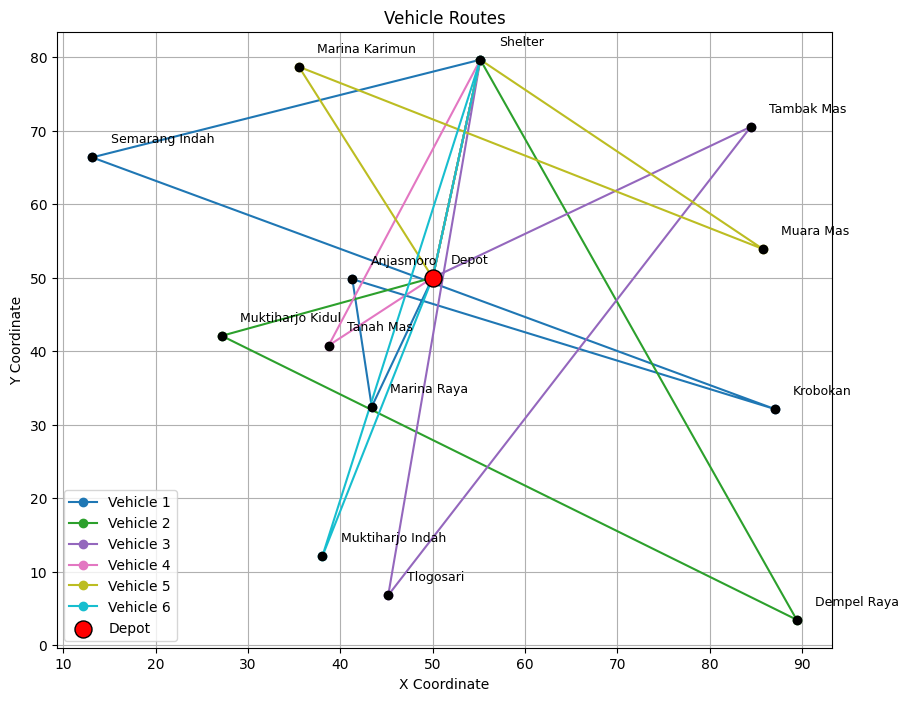

Iteration 0: Best Fitness = 198.5
Iteration 10: Best Fitness = 194.0
Iteration 20: Best Fitness = 186.99999999999997
Iteration 30: Best Fitness = 186.99999999999997
Iteration 40: Best Fitness = 186.99999999999997
Iteration 50: Best Fitness = 186.99999999999997
Iteration 60: Best Fitness = 186.99999999999997
Iteration 70: Best Fitness = 186.0
Iteration 80: Best Fitness = 186.0
Iteration 90: Best Fitness = 186.0

Hasil Optimasi:
Total Jarak: 186.0

Rute Kendaraan 1:
Depot -> Anjasmoro -> Krobokan -> Semarang Indah -> Marina Raya -> Shelter -> Depot
Jarak: 30.400000000000002
Total Demand: 30/30

Rute Kendaraan 2:
Depot -> Tanah Mas -> Shelter -> Depot
Jarak: 26.8
Total Demand: 29/30

Rute Kendaraan 3:
Depot -> Marina Karimun -> Muara Mas -> Shelter -> Depot
Jarak: 28.7
Total Demand: 29/30

Rute Kendaraan 4:
Depot -> Tambak Mas -> Muktiharjo Indah -> Shelter -> Depot
Jarak: 34.7
Total Demand: 29/30

Rute Kendaraan 5:
Depot -> Dempel Raya -> Muktiharjo Kidul -> Shelter -> Depot
Jarak: 32.09

In [ ]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import numpy as np

# Data masalah
locations = [
    "Depot", "Marina Raya", "Marina Karimun", "Tlogosari", "Dempel Raya",
    "Muktiharjo Kidul", "Muktiharjo Indah", "Anjasmoro", "Krobokan", "Tanah Mas", "Semarang Indah",
    "Muara Mas", "Tambak Mas", "Shelter"
]

distances = [
    [0, 9.7, 10.1, 16.4, 15.1, 15.2, 15.8, 7.9, 8.5, 11.9, 9.1, 11, 10.7, 10.6],
    [9.1, 0, 1.5, 11.7, 10.5, 10.6, 10.9, 3.3, 4.1, 4, 3.2, 3.2, 3.2, 6.3],
    [9.9, 0.8, 0, 12.1, 10.9, 11, 10.7, 3, 3.8, 3.8, 2.7, 2.9, 2.9, 7.1],
    [15.5, 13.7, 13.3, 0, 2.3, 2.2, 2.6, 9.9, 9.2, 8.7, 9.7, 10.8, 9.9, 6.4],
    [15.5, 12.7, 12.3, 2.9, 0, 0.2, 0.2, 11.9, 9.7, 7.7, 9.8, 10.1, 9.8, 6.2],
    [15.6, 12.7, 12.3, 2.5, 0.2, 0, 0.2, 12.5, 9.3, 8.1, 10.2, 9.8, 10.2, 6.3],
    [16.5, 11.5, 12.1, 2.6, 0.2, 0.2, 0, 9.5, 8.5, 7.2, 9.6, 8, 9.6, 5.7],
    [7.2, 3.8, 3.4, 10.6, 9.4, 9.5, 10.1, 0, 1.3, 5.2, 2.7, 4.3, 5, 4.9],
    [9, 4.5, 4.1, 9.7, 8.5, 9, 9.2, 1.3, 0, 4.3, 1.2, 5, 4.1, 4],
    [11.9, 5.7, 5.3, 8.4, 7.1, 7.5, 7.8, 5, 4.7, 0, 4.6, 1.1, 1, 4.4],
    [9.7, 3.2, 2.9, 10.8, 9.5, 9.6, 10.3, 2.7, 1.7, 4.6, 0, 3.8, 3.8, 5],
    [11, 4.8, 4.4, 9.2, 7.9, 8, 9.8, 4.1, 4.9, 1.1, 3.7, 0, 0.3, 5.2],
    [11, 4.8, 4.5, 8.7, 7.5, 7.8, 7.8, 4.1, 4.9, 1, 3.8, 0.3, 0, 5.8],
    [10.5, 7.2, 7.6, 6, 6.9, 7, 7.1, 4.9, 4.2, 4.8, 4.8, 5.6, 5.4, 0]
]

class HybridAntFireworksOptimization:
    def __init__(self, problem_params):
        # Problem Parameters
        self.problem_size = problem_params['problem_size']
        self.num_vehicles = problem_params['num_vehicles']
        self.vehicle_capacity = problem_params['vehicle_capacity']
        self.demands = problem_params['demands']
        self.depot = problem_params['depot']
        self.shelter = problem_params['shelter']
        self.locations = problem_params['locations']

        # ACO Parameters
        self.num_ants = problem_params['num_ants']
        self.max_iterations = problem_params['max_iterations']
        self.alpha = problem_params['alpha']
        self.beta = problem_params['beta']
        self.evaporation_rate = problem_params['evaporation_rate']

        # Fireworks Parameters
        self.A_cap = problem_params['A_cap']
        self.M = problem_params['M']
        self.a = problem_params['a']
        self.b = problem_params['b']

        # Pheromone Parameters
        self.Q = problem_params['Q']
        self.tau_min = problem_params['tau_min']
        self.tau_max = problem_params['tau_max']

        # Initialize matrices
        self.y = np.zeros((self.problem_size, self.num_vehicles))
        self.x = np.zeros((self.problem_size, self.problem_size, self.num_vehicles))
        self.q = np.zeros((self.problem_size, self.num_vehicles))

        # Initialize data structures
        self.pheromone_matrix = None
        self.distance_matrix = None
        self.best_solution = None
        self.best_fitness = float('inf')
        self.iteration_history = []

    def initialize_problem(self, distance_matrix):
        """Initialize problem-specific components"""
        self.distance_matrix = distance_matrix
        self.pheromone_matrix = np.ones_like(distance_matrix) * self.tau_min
        self.population = self.generate_initial_population()

    def generate_initial_population(self):
        """Generate initial population of solutions"""
        population = []
        for _ in range(self.num_ants):
            # Generate random solution
            solution = list(range(1, self.problem_size-1))  # Exclude depot and shelter
            random.shuffle(solution)
            # Add depot at start and shelter at end
            solution = [self.depot] + solution + [self.shelter]
            population.append(solution)
        return population

    def is_route_feasible(self, route):
        """Check if route satisfies all constraints"""
        if not route:
            return False

        # Check if route starts from depot and ends at shelter
        if route[0] != self.depot or route[-1] != self.shelter:
            return False

        # Check capacity constraint
        total_demand = sum(self.demands[i] for i in route[1:-1])  # Exclude depot and shelter
        if total_demand > self.vehicle_capacity:
            return False

        # Check if all locations in route are unique (except depot/shelter)
        visited = set(route[1:-1])
        if len(visited) != len(route[1:-1]):
            return False

        return True

    def calculate_route_fitness(self, route):
        """Calculate fitness (total distance) for a single route"""
        if not route or len(route) < 2:
            return float('inf')

        total_distance = 0
        for i in range(len(route) - 1):
            total_distance += self.distance_matrix[route[i]][route[i+1]]

        # Add distance back to depot from shelter
        total_distance += self.distance_matrix[self.shelter][self.depot]

        return total_distance

    def calculate_fitness(self, solution):
        """Calculate solution fitness considering multiple vehicles"""
        routes = self.split_into_vehicle_routes(solution)
        if routes is None:
            return float('inf')

        total_fitness = 0
        visited_locations = set()

        for route in routes:
            # Check route feasibility
            if not self.is_route_feasible(route):
                return float('inf')

            # Add locations to visited set (excluding depot and shelter)
            visited_locations.update(route[1:-1])

            # Add route distance
            total_fitness += self.calculate_route_fitness(route)

        # Check if all locations are visited exactly once
        required_locations = set(range(1, self.problem_size-1))  # Exclude depot and shelter
        if visited_locations != required_locations:
            return float('inf')

        return total_fitness

    def split_into_vehicle_routes(self, solution):
        """Split a complete solution into feasible vehicle routes"""
        if not solution:
            return None

        routes = []
        current_route = [self.depot]
        current_load = 0

        for node in solution[1:]:  # Skip first node (depot)
            if node == self.shelter:  # End of route
                if len(current_route) > 1:  # Only add route if it contains customers
                    current_route.append(self.shelter)
                    routes.append(current_route)
                    current_route = [self.depot]
                    current_load = 0
                continue

            # Check if adding this node exceeds vehicle capacity
            if current_load + self.demands[node] <= self.vehicle_capacity:
                current_route.append(node)
                current_load += self.demands[node]
            else:
                # Finish current route
                if len(current_route) > 1:
                    current_route.append(self.shelter)
                    routes.append(current_route)

                # Start new route
                if len(routes) < self.num_vehicles:
                    current_route = [self.depot, node]
                    current_load = self.demands[node]
                else:
                    return None  # Cannot create feasible routes

        # Add final route if not empty
        if len(current_route) > 1:
            current_route.append(self.shelter)
            routes.append(current_route)

        # Check if we have a valid number of routes
        if len(routes) > self.num_vehicles:
            return None

        # Verify all routes visit shelter
        for route in routes:
            if route[-1] != self.shelter:
                route.append(self.shelter)

        return routes

    def update_solution_matrices(self, routes):
        """Update CVRP solution matrices (x, y, q)"""
        # Reset matrices
        self.y.fill(0)
        self.x.fill(0)
        self.q.fill(0)

        # Update matrices for each vehicle route
        for k, route in enumerate(routes):
            current_load = 0
            for i in range(len(route) - 1):
                current = route[i]
                next_node = route[i + 1]

                # Update x (route) matrix
                self.x[current, next_node, k] = 1

                # Update y (visit) matrix
                self.y[current, k] = 1

                # Update q (load) matrix
                if current != self.depot and current != self.shelter:
                    current_load += self.demands[current]
                self.q[current, k] = current_load

            # Add return to depot after shelter
            if route[-1] == self.shelter:
                self.x[self.shelter, self.depot, k] = 1

    def transition_probability(self, current_node, unvisited, current_load=0):
        """Calculate transition probabilities considering capacity constraints"""
        probabilities = []
        total = 0

        for node in unvisited:
            # Skip if adding node would exceed capacity
            if current_load + self.demands[node] > self.vehicle_capacity:
                continue

            # Calculate probability based on pheromone and distance
            pheromone = self.pheromone_matrix[current_node][node] ** self.alpha
            distance = (1.0 / (self.distance_matrix[current_node][node] + 1e-10)) ** self.beta
            probability = pheromone * distance

            probabilities.append((node, probability))
            total += probability

        # If no feasible nodes found, force return to shelter
        if not probabilities:
            return [(self.shelter, 1.0)]

        # Normalize probabilities
        return [(node, prob/total) for node, prob in probabilities]

    def probabilistic_selection(self, probabilities):
        """Select next node based on probabilities"""
        r = random.random()
        cumulative = 0
        for node, prob in probabilities:
            cumulative += prob
            if r <= cumulative:
                return node
        return probabilities[-1][0] if probabilities else self.shelter

    def construct_ant_solutions(self):
        """Construct solutions for each ant considering vehicle constraints"""
        solutions = []

        for _ in range(self.num_ants):
            all_routes = []
            unvisited = set(range(1, self.problem_size-1))  # Exclude depot and shelter

            while unvisited and len(all_routes) < self.num_vehicles:
                route = [self.depot]
                current_node = self.depot
                current_load = 0
                route_unvisited = unvisited.copy()

                while route_unvisited:
                    # Calculate probabilities for next node
                    probabilities = self.transition_probability(
                        current_node, route_unvisited, current_load)

                    # Select next node
                    next_node = self.probabilistic_selection(probabilities)

                    if next_node == self.shelter:
                        break

                    route.append(next_node)
                    current_node = next_node
                    current_load += self.demands[next_node]
                    unvisited.remove(next_node)
                    route_unvisited.remove(next_node)

                # Add shelter to end of route
                route.append(self.shelter)

                if len(route) > 2:  # Only add route if it contains customers
                    all_routes.append(route)

            # Create complete solution
            if len(all_routes) > 0:
                complete_solution = [self.depot]
                for route in all_routes:
                    complete_solution.extend(route[1:])  # Skip depot from each route
                solutions.append(complete_solution)

        return solutions

    def generate_fireworks_sparks(self, solutions):
        """Generate sparks using Fireworks Algorithm for CVRP"""
        if not solutions:
            return []

        # Calculate fitness values
        fitness_values = [self.calculate_fitness(sol) for sol in solutions]
        max_fitness = max(fitness_values)
        min_fitness = min(fitness_values)

        # Calculate spark counts
        spark_counts = []
        total_sparks = self.M

        if max_fitness == min_fitness:
            # Equal distribution if all solutions have same fitness
            base_sparks = total_sparks // len(solutions)
            spark_counts = [base_sparks] * len(solutions)
        else:
            for fitness in fitness_values:
                # Calculate normalized spark count
                spark_count = total_sparks * (max_fitness - fitness) / \
                            (sum(max_fitness - f for f in fitness_values) + 1e-10)
                spark_counts.append(spark_count)

        # Limit spark counts
        limited_sparks = self.limit_sparks(spark_counts)

        # Generate sparks
        all_sparks = []
        for sol, num_sparks in zip(solutions, limited_sparks):
            routes = self.split_into_vehicle_routes(sol)
            if routes:
                for _ in range(int(num_sparks)):
                    spark = self.cvrp_mutation(routes, 0.5)  # Fixed amplitude
                    if spark:
                        flat_spark = [self.depot]
                        for route in spark[:-1]:
                            flat_spark.extend(route[1:-1])
                        flat_spark.extend(spark[-1][1:])
                        all_sparks.append(flat_spark)

        return all_sparks

    def calculate_explosion_amplitude(self, fitness_values):
        """Calculate explosion amplitudes for fireworks"""
        if not fitness_values:
            return []

        min_fitness = min(fitness_values)
        max_fitness = max(fitness_values)

        if max_fitness == min_fitness:
            return [self.A_cap / len(fitness_values)] * len(fitness_values)

        amplitudes = []
        for fitness in fitness_values:
            amplitude = self.A_cap * (max_fitness - fitness) / \
                       (max_fitness - min_fitness + 1e-10)
            amplitudes.append(max(0.1, min(amplitude, self.A_cap)))

        return amplitudes

    def limit_sparks(self, spark_counts):
        """Limit number of sparks for each solution"""
        min_sparks = max(1, round(self.a * self.M))
        max_sparks = round(self.b * self.M)

        limited_sparks = []
        for count in spark_counts:
            if np.isnan(count) or np.isinf(count):
                count = min_sparks
            count = round(float(count))
            count = max(min_sparks, min(count, max_sparks))
            limited_sparks.append(count)

        return limited_sparks

    def cvrp_mutation(self, routes, amplitude):
        """Mutation operator specifically for CVRP solutions"""
        if not routes:
            return None

        mutated_routes = [route.copy() for route in routes]
        num_mutations = max(1, int(amplitude * 3))
        success = False
        max_attempts = 5

        for _ in range(max_attempts):
            temp_routes = [route.copy() for route in mutated_routes]

            for _ in range(num_mutations):
                mutation_type = random.choice(['swap', 'reverse', 'relocate'])

                if mutation_type == 'swap':
                    # Between routes swap
                    if len(temp_routes) > 1 and random.random() < 0.5:
                        route1_idx = random.randint(0, len(temp_routes)-1)
                        route2_idx = random.randint(0, len(temp_routes)-1)
                        if route1_idx != route2_idx:
                            route1 = temp_routes[route1_idx]
                            route2 = temp_routes[route2_idx]
                            if len(route1) > 3 and len(route2) > 3:
                                pos1 = random.randint(1, len(route1)-2)
                                pos2 = random.randint(1, len(route2)-2)
                                route1[pos1], route2[pos2] = route2[pos2], route1[pos1]
                    # Within route swap
                    else:
                        if temp_routes:
                            route_idx = random.randint(0, len(temp_routes)-1)
                            route = temp_routes[route_idx]
                            if len(route) > 3:
                                pos1, pos2 = random.sample(range(1, len(route)-1), 2)
                                route[pos1], route[pos2] = route[pos2], route[pos1]

                elif mutation_type == 'reverse':
                    if temp_routes:
                        route_idx = random.randint(0, len(temp_routes)-1)
                        route = temp_routes[route_idx]
                        if len(route) > 3:
                            start = random.randint(1, len(route)-3)
                            end = random.randint(start+1, len(route)-2)
                            route[start:end+1] = reversed(route[start:end+1])

                elif mutation_type == 'relocate':
                    if len(temp_routes) > 1:
                        from_route_idx = random.randint(0, len(temp_routes)-1)
                        to_route_idx = random.randint(0, len(temp_routes)-1)
                        from_route = temp_routes[from_route_idx]
                        to_route = temp_routes[to_route_idx]

                        if len(from_route) > 3:
                            node_idx = random.randint(1, len(from_route)-2)
                            node = from_route.pop(node_idx)
                            insert_pos = random.randint(1, len(to_route)-1)
                            to_route.insert(insert_pos, node)

            # Verify feasibility
            if all(self.is_route_feasible(route) for route in temp_routes):
                mutated_routes = temp_routes
                success = True
                break

        return mutated_routes if success else None

    def update_pheromone_local(self, routes):
        """Local pheromone update for routes"""
        if not routes:
            return

        for route in routes:
            route_distance = self.calculate_route_fitness(route)
            if route_distance == float('inf'):
                continue

            deposit = self.Q / route_distance
            for i in range(len(route) - 1):
                self.pheromone_matrix[route[i]][route[i+1]] = \
                    (1 - self.evaporation_rate) * self.pheromone_matrix[route[i]][route[i+1]] + \
                    deposit
                # Symmetric update
                self.pheromone_matrix[route[i+1]][route[i]] = \
                    self.pheromone_matrix[route[i]][route[i+1]]

    def update_pheromone_global(self, best_solution):
        """Global pheromone update for best solution"""
        if best_solution is None:
            return

        routes = self.split_into_vehicle_routes(best_solution)
        if not routes:
            return

        for route in routes:
            route_distance = self.calculate_route_fitness(route)
            if route_distance == float('inf'):
                continue

            deposit = self.Q / route_distance
            for i in range(len(route) - 1):
                self.pheromone_matrix[route[i]][route[i+1]] += deposit
                # Symmetric update
                self.pheromone_matrix[route[i+1]][route[i]] = \
                    self.pheromone_matrix[route[i]][route[i+1]]

        # Enforce pheromone bounds
        self.pheromone_matrix = np.clip(self.pheromone_matrix, self.tau_min, self.tau_max)

    def optimize(self, distance_matrix):
        """Main optimization process"""
        self.initialize_problem(distance_matrix)

        for iteration in range(self.max_iterations):
            # Construct solutions
            ant_solutions = self.construct_ant_solutions()

            # Generate fireworks sparks
            spark_solutions = self.generate_fireworks_sparks(ant_solutions)

            # Combine solutions
            all_solutions = ant_solutions + spark_solutions

            # Filter feasible solutions
            feasible_solutions = [
                sol for sol in all_solutions
                if self.split_into_vehicle_routes(sol) is not None
            ]

            if not feasible_solutions:
                continue

            # Update best solution
            current_best = min(feasible_solutions, key=self.calculate_fitness)
            current_fitness = self.calculate_fitness(current_best)

            if current_fitness < self.best_fitness:
                self.best_solution = current_best
                self.best_fitness = current_fitness

                # Update matrices for best solution
                best_routes = self.split_into_vehicle_routes(current_best)
                if best_routes:
                    self.update_solution_matrices(best_routes)

            # Update pheromones
            for solution in feasible_solutions:
                routes = self.split_into_vehicle_routes(solution)
                if routes:
                    self.update_pheromone_local(routes)

            self.update_pheromone_global(self.best_solution)

            # Store history
            self.iteration_history.append({
                'iteration': iteration,
                'best_fitness': self.best_fitness
            })

            if iteration % 10 == 0:
                print(f"Iteration {iteration}: Best Fitness = {self.best_fitness}")

        return self.best_solution, self.best_fitness, self.iteration_history



    def plot_routes(locations, distances, best_routes, depot_index=0, shelter_index=-1):
      num_locations = len(locations)
      coords = np.random.rand(num_locations, 2) * 100  # Example: coordinates in 100x100 space
      coords[depot_index] = [50, 50]  # Depot at the center
      if shelter_index != -1:
        coords[shelter_index] = [75, 75]  # Shelter at a different fixed location

      plt.figure(figsize=(10, 8))
      plt.scatter(coords[:, 0], coords[:, 1], c='black', zorder=3)
      for i, loc in enumerate(locations):
        plt.text(coords[i, 0] + 2, coords[i, 1] + 2, loc, fontsize=9)

      colors = plt.cm.get_cmap('tab10', len(best_routes))
      for i, route in enumerate(best_routes):
        route_coords = coords[route]
        route_coords = np.vstack((route_coords, route_coords[0]))  # Add return to depot/shelter
        plt.plot(route_coords[:, 0], route_coords[:, 1], marker='o', color=colors(i), label=f'Vehicle {i+1}', zorder=2)

      plt.scatter(coords[depot_index, 0], coords[depot_index, 1], c='red', label='Depot', zorder=4, edgecolors='black', s=150)
      if shelter_index != -1:
        plt.scatter(coords[shelter_index, 0], coords[shelter_index, 1], c='blue', label='Shelter', zorder=4, edgecolors='black', s=150)

    # Add legend and grid
      plt.legend()
      plt.grid(True)
      plt.title('Vehicle Routes')
      plt.xlabel('X Coordinate')
      plt.ylabel('Y Coordinate')
      plt.show()

# Panggil fungsi visualisasi
    plot_routes(locations, distances, best_routes, depot_index=0, shelter_index=-1)


# Main program
if __name__ == "__main__":
    # Problem parameters
    problem_params = {
        'problem_size': len(locations),
        'num_vehicles': 6,
        'vehicle_capacity': 30,
        'demands': [0,26,20,18,2,25,25,2,1,29,1,9,4,0],
        'depot': 0,
        'shelter': 13,
        'locations': locations,
        'num_ants': 2,
        'max_iterations': 100,
        'alpha': 1,
        'beta': 3,
        'evaporation_rate': 0.5,
        'A_cap': 40,
        'M': 50,
        'a': 0.08,
        'b': 0.4,
        'Q': 20,
        'tau_min': 0.1,
        'tau_max': 1.0
    }

    # Create and run optimizer
    optimizer = HybridAntFireworksOptimization(problem_params)
    best_solution, best_fitness, iteration_history = optimizer.optimize(np.array(distances))


    # Print results
    print("\nHasil Optimasi:")
    print(f"Total Jarak: {best_fitness}")

    best_routes = optimizer.split_into_vehicle_routes(best_solution)
    if best_routes:
        for i, route in enumerate(best_routes):
            print(f"\nRute Kendaraan {i+1}:")
            route_locations = [locations[j] for j in route]
            route_with_shelter_and_depot = " -> ".join(route_locations) + " -> Depot"
            print(route_with_shelter_and_depot)

            # Route details
            route_distance = optimizer.calculate_route_fitness(route)
            route_demand = sum(problem_params['demands'][j] for j in route[1:-1])
            print(f"Jarak: {route_distance}")
            print(f"Total Demand: {route_demand}/{problem_params['vehicle_capacity']}")

        # Print statistics
        print("\nStatistik:")
        total_demand = sum(sum(problem_params['demands'][j] for j in route[1:-1])
                         for route in best_routes)
        print(f"Jumlah kendaraan yang digunakan: {len(best_routes)}")
        print(f"Total demand yang dilayani: {total_demand}")
        print(f"Utilisasi kapasitas: {total_demand/(len(best_routes)*problem_params['vehicle_capacity'])*100:.2f}%")

<ipython-input-22-5ddb801366d9>:570: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(best_routes))


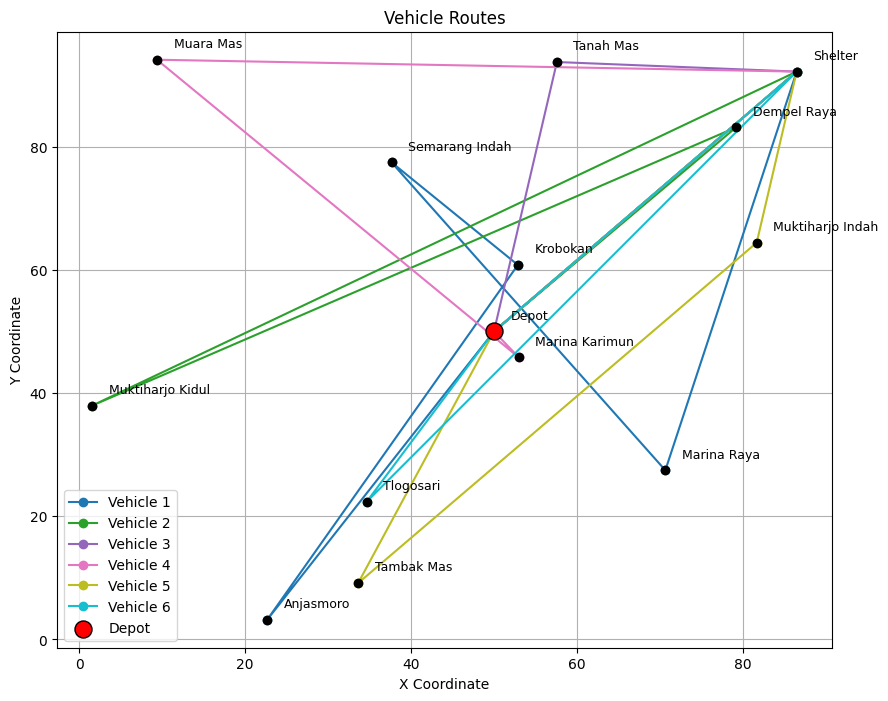

Iteration 0: Best Fitness = 191.5
Iteration 10: Best Fitness = 191.1
Iteration 20: Best Fitness = 191.1
Iteration 30: Best Fitness = 188.2
Iteration 40: Best Fitness = 188.2
Iteration 50: Best Fitness = 188.2
Iteration 60: Best Fitness = 187.5
Iteration 70: Best Fitness = 186.7
Iteration 80: Best Fitness = 186.0
Iteration 90: Best Fitness = 186.0

Hasil Optimasi:
Total Jarak: 186.0

Rute Kendaraan 1:
Depot -> Anjasmoro -> Krobokan -> Semarang Indah -> Marina Raya -> Shelter -> Depot
Jarak: 30.4
Total Demand: 30/30

Rute Kendaraan 2:
Depot -> Tanah Mas -> Shelter -> Depot
Jarak: 26.8
Total Demand: 29/30

Rute Kendaraan 3:
Depot -> Marina Karimun -> Muara Mas -> Shelter -> Depot
Jarak: 28.7
Total Demand: 29/30

Rute Kendaraan 4:
Depot -> Tambak Mas -> Muktiharjo Indah -> Shelter -> Depot
Jarak: 34.7
Total Demand: 29/30

Rute Kendaraan 5:
Depot -> Muktiharjo Kidul -> Dempel Raya -> Shelter -> Depot
Jarak: 32.1
Total Demand: 27/30

Rute Kendaraan 6:
Depot -> Tlogosari -> Shelter -> Depot
J

<ipython-input-22-5ddb801366d9>:661: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(best_routes))


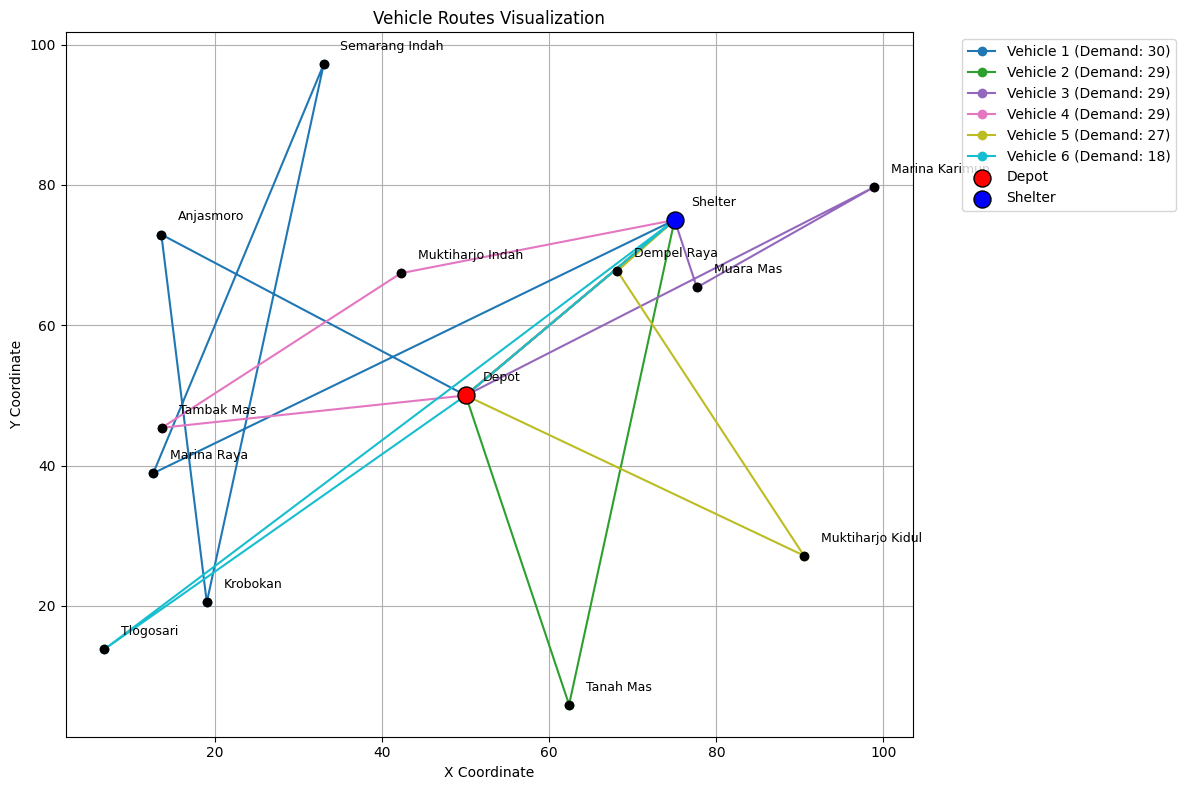

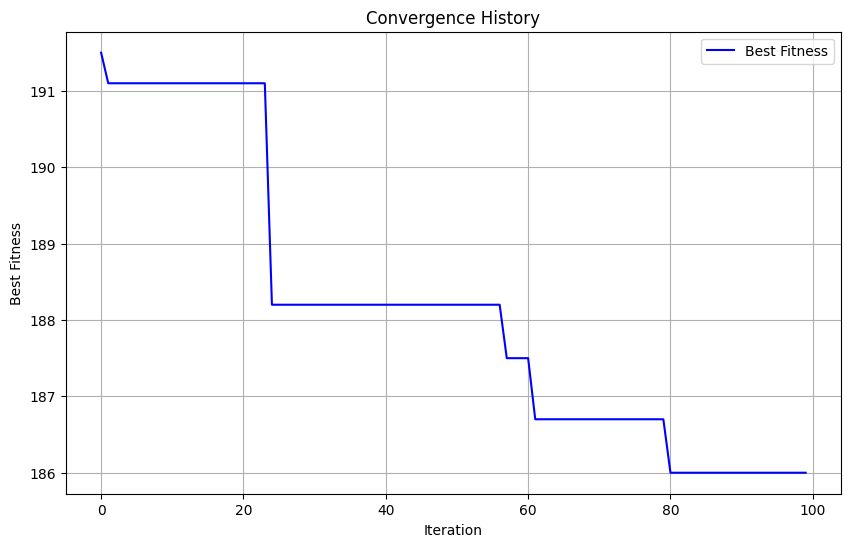

In [ ]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import numpy as np

# Data masalah
locations = [
    "Depot", "Marina Raya", "Marina Karimun", "Tlogosari", "Dempel Raya",
    "Muktiharjo Kidul", "Muktiharjo Indah", "Anjasmoro", "Krobokan", "Tanah Mas", "Semarang Indah",
    "Muara Mas", "Tambak Mas", "Shelter"
]

distances = [
    [0, 9.7, 10.1, 16.4, 15.1, 15.2, 15.8, 7.9, 8.5, 11.9, 9.1, 11, 10.7, 10.6],
    [9.1, 0, 1.5, 11.7, 10.5, 10.6, 10.9, 3.3, 4.1, 4, 3.2, 3.2, 3.2, 6.3],
    [9.9, 0.8, 0, 12.1, 10.9, 11, 10.7, 3, 3.8, 3.8, 2.7, 2.9, 2.9, 7.1],
    [15.5, 13.7, 13.3, 0, 2.3, 2.2, 2.6, 9.9, 9.2, 8.7, 9.7, 10.8, 9.9, 6.4],
    [15.5, 12.7, 12.3, 2.9, 0, 0.2, 0.2, 11.9, 9.7, 7.7, 9.8, 10.1, 9.8, 6.2],
    [15.6, 12.7, 12.3, 2.5, 0.2, 0, 0.2, 12.5, 9.3, 8.1, 10.2, 9.8, 10.2, 6.3],
    [16.5, 11.5, 12.1, 2.6, 0.2, 0.2, 0, 9.5, 8.5, 7.2, 9.6, 8, 9.6, 5.7],
    [7.2, 3.8, 3.4, 10.6, 9.4, 9.5, 10.1, 0, 1.3, 5.2, 2.7, 4.3, 5, 4.9],
    [9, 4.5, 4.1, 9.7, 8.5, 9, 9.2, 1.3, 0, 4.3, 1.2, 5, 4.1, 4],
    [11.9, 5.7, 5.3, 8.4, 7.1, 7.5, 7.8, 5, 4.7, 0, 4.6, 1.1, 1, 4.4],
    [9.7, 3.2, 2.9, 10.8, 9.5, 9.6, 10.3, 2.7, 1.7, 4.6, 0, 3.8, 3.8, 5],
    [11, 4.8, 4.4, 9.2, 7.9, 8, 9.8, 4.1, 4.9, 1.1, 3.7, 0, 0.3, 5.2],
    [11, 4.8, 4.5, 8.7, 7.5, 7.8, 7.8, 4.1, 4.9, 1, 3.8, 0.3, 0, 5.8],
    [10.5, 7.2, 7.6, 6, 6.9, 7, 7.1, 4.9, 4.2, 4.8, 4.8, 5.6, 5.4, 0]
]

class HybridAntFireworksOptimization:
    def __init__(self, problem_params):
        # Problem Parameters
        self.problem_size = problem_params['problem_size']
        self.num_vehicles = problem_params['num_vehicles']
        self.vehicle_capacity = problem_params['vehicle_capacity']
        self.demands = problem_params['demands']
        self.depot = problem_params['depot']
        self.shelter = problem_params['shelter']
        self.locations = problem_params['locations']

        # ACO Parameters
        self.num_ants = problem_params['num_ants']
        self.max_iterations = problem_params['max_iterations']
        self.alpha = problem_params['alpha']
        self.beta = problem_params['beta']
        self.evaporation_rate = problem_params['evaporation_rate']

        # Fireworks Parameters
        self.A_cap = problem_params['A_cap']
        self.M = problem_params['M']
        self.a = problem_params['a']
        self.b = problem_params['b']

        # Pheromone Parameters
        self.Q = problem_params['Q']
        self.tau_min = problem_params['tau_min']
        self.tau_max = problem_params['tau_max']

        # Initialize matrices
        self.y = np.zeros((self.problem_size, self.num_vehicles))
        self.x = np.zeros((self.problem_size, self.problem_size, self.num_vehicles))
        self.q = np.zeros((self.problem_size, self.num_vehicles))

        # Initialize data structures
        self.pheromone_matrix = None
        self.distance_matrix = None
        self.best_solution = None
        self.best_fitness = float('inf')
        self.iteration_history = []

    def initialize_problem(self, distance_matrix):
        """Initialize problem-specific components"""
        self.distance_matrix = distance_matrix
        self.pheromone_matrix = np.ones_like(distance_matrix) * self.tau_min
        self.population = self.generate_initial_population()

    def generate_initial_population(self):
        """Generate initial population of solutions"""
        population = []
        for _ in range(self.num_ants):
            # Generate random solution
            solution = list(range(1, self.problem_size-1))  # Exclude depot and shelter
            random.shuffle(solution)
            # Add depot at start and shelter at end
            solution = [self.depot] + solution + [self.shelter]
            population.append(solution)
        return population

    def is_route_feasible(self, route):
        """Check if route satisfies all constraints"""
        if not route:
            return False

        # Check if route starts from depot and ends at shelter
        if route[0] != self.depot or route[-1] != self.shelter:
            return False

        # Check capacity constraint
        total_demand = sum(self.demands[i] for i in route[1:-1])  # Exclude depot and shelter
        if total_demand > self.vehicle_capacity:
            return False

        # Check if all locations in route are unique (except depot/shelter)
        visited = set(route[1:-1])
        if len(visited) != len(route[1:-1]):
            return False

        return True

    def calculate_route_fitness(self, route):
        """Calculate fitness (total distance) for a single route"""
        if not route or len(route) < 2:
            return float('inf')

        total_distance = 0
        for i in range(len(route) - 1):
            total_distance += self.distance_matrix[route[i]][route[i+1]]

        # Add distance back to depot from shelter
        total_distance += self.distance_matrix[self.shelter][self.depot]

        return total_distance

    def calculate_fitness(self, solution):
        """Calculate solution fitness considering multiple vehicles"""
        routes = self.split_into_vehicle_routes(solution)
        if routes is None:
            return float('inf')

        total_fitness = 0
        visited_locations = set()

        for route in routes:
            # Check route feasibility
            if not self.is_route_feasible(route):
                return float('inf')

            # Add locations to visited set (excluding depot and shelter)
            visited_locations.update(route[1:-1])

            # Add route distance
            total_fitness += self.calculate_route_fitness(route)

        # Check if all locations are visited exactly once
        required_locations = set(range(1, self.problem_size-1))  # Exclude depot and shelter
        if visited_locations != required_locations:
            return float('inf')

        return total_fitness

    def split_into_vehicle_routes(self, solution):
        """Split a complete solution into feasible vehicle routes"""
        if not solution:
            return None

        routes = []
        current_route = [self.depot]
        current_load = 0

        for node in solution[1:]:  # Skip first node (depot)
            if node == self.shelter:  # End of route
                if len(current_route) > 1:  # Only add route if it contains customers
                    current_route.append(self.shelter)
                    routes.append(current_route)
                    current_route = [self.depot]
                    current_load = 0
                continue

            # Check if adding this node exceeds vehicle capacity
            if current_load + self.demands[node] <= self.vehicle_capacity:
                current_route.append(node)
                current_load += self.demands[node]
            else:
                # Finish current route
                if len(current_route) > 1:
                    current_route.append(self.shelter)
                    routes.append(current_route)

                # Start new route
                if len(routes) < self.num_vehicles:
                    current_route = [self.depot, node]
                    current_load = self.demands[node]
                else:
                    return None  # Cannot create feasible routes

        # Add final route if not empty
        if len(current_route) > 1:
            current_route.append(self.shelter)
            routes.append(current_route)

        # Check if we have a valid number of routes
        if len(routes) > self.num_vehicles:
            return None

        # Verify all routes visit shelter
        for route in routes:
            if route[-1] != self.shelter:
                route.append(self.shelter)

        return routes

    def update_solution_matrices(self, routes):
        """Update CVRP solution matrices (x, y, q)"""
        # Reset matrices
        self.y.fill(0)
        self.x.fill(0)
        self.q.fill(0)

        # Update matrices for each vehicle route
        for k, route in enumerate(routes):
            current_load = 0
            for i in range(len(route) - 1):
                current = route[i]
                next_node = route[i + 1]

                # Update x (route) matrix
                self.x[current, next_node, k] = 1

                # Update y (visit) matrix
                self.y[current, k] = 1

                # Update q (load) matrix
                if current != self.depot and current != self.shelter:
                    current_load += self.demands[current]
                self.q[current, k] = current_load

            # Add return to depot after shelter
            if route[-1] == self.shelter:
                self.x[self.shelter, self.depot, k] = 1

    def transition_probability(self, current_node, unvisited, current_load=0):
        """Calculate transition probabilities considering capacity constraints"""
        probabilities = []
        total = 0

        for node in unvisited:
            # Skip if adding node would exceed capacity
            if current_load + self.demands[node] > self.vehicle_capacity:
                continue

            # Calculate probability based on pheromone and distance
            pheromone = self.pheromone_matrix[current_node][node] ** self.alpha
            distance = (1.0 / (self.distance_matrix[current_node][node] + 1e-10)) ** self.beta
            probability = pheromone * distance

            probabilities.append((node, probability))
            total += probability

        # If no feasible nodes found, force return to shelter
        if not probabilities:
            return [(self.shelter, 1.0)]

        # Normalize probabilities
        return [(node, prob/total) for node, prob in probabilities]

    def probabilistic_selection(self, probabilities):
        """Select next node based on probabilities"""
        r = random.random()
        cumulative = 0
        for node, prob in probabilities:
            cumulative += prob
            if r <= cumulative:
                return node
        return probabilities[-1][0] if probabilities else self.shelter

    def construct_ant_solutions(self):
        """Construct solutions for each ant considering vehicle constraints"""
        solutions = []

        for _ in range(self.num_ants):
            all_routes = []
            unvisited = set(range(1, self.problem_size-1))  # Exclude depot and shelter

            while unvisited and len(all_routes) < self.num_vehicles:
                route = [self.depot]
                current_node = self.depot
                current_load = 0
                route_unvisited = unvisited.copy()

                while route_unvisited:
                    # Calculate probabilities for next node
                    probabilities = self.transition_probability(
                        current_node, route_unvisited, current_load)

                    # Select next node
                    next_node = self.probabilistic_selection(probabilities)

                    if next_node == self.shelter:
                        break

                    route.append(next_node)
                    current_node = next_node
                    current_load += self.demands[next_node]
                    unvisited.remove(next_node)
                    route_unvisited.remove(next_node)

                # Add shelter to end of route
                route.append(self.shelter)

                if len(route) > 2:  # Only add route if it contains customers
                    all_routes.append(route)

            # Create complete solution
            if len(all_routes) > 0:
                complete_solution = [self.depot]
                for route in all_routes:
                    complete_solution.extend(route[1:])  # Skip depot from each route
                solutions.append(complete_solution)

        return solutions

    def generate_fireworks_sparks(self, solutions):
        """Generate sparks using Fireworks Algorithm for CVRP"""
        if not solutions:
            return []

        # Calculate fitness values
        fitness_values = [self.calculate_fitness(sol) for sol in solutions]
        max_fitness = max(fitness_values)
        min_fitness = min(fitness_values)

        # Calculate spark counts
        spark_counts = []
        total_sparks = self.M

        if max_fitness == min_fitness:
            # Equal distribution if all solutions have same fitness
            base_sparks = total_sparks // len(solutions)
            spark_counts = [base_sparks] * len(solutions)
        else:
            for fitness in fitness_values:
                # Calculate normalized spark count
                spark_count = total_sparks * (max_fitness - fitness) / \
                            (sum(max_fitness - f for f in fitness_values) + 1e-10)
                spark_counts.append(spark_count)

        # Limit spark counts
        limited_sparks = self.limit_sparks(spark_counts)

        # Generate sparks
        all_sparks = []
        for sol, num_sparks in zip(solutions, limited_sparks):
            routes = self.split_into_vehicle_routes(sol)
            if routes:
                for _ in range(int(num_sparks)):
                    spark = self.cvrp_mutation(routes, 0.5)  # Fixed amplitude
                    if spark:
                        flat_spark = [self.depot]
                        for route in spark[:-1]:
                            flat_spark.extend(route[1:-1])
                        flat_spark.extend(spark[-1][1:])
                        all_sparks.append(flat_spark)

        return all_sparks

    def calculate_explosion_amplitude(self, fitness_values):
        """Calculate explosion amplitudes for fireworks"""
        if not fitness_values:
            return []

        min_fitness = min(fitness_values)
        max_fitness = max(fitness_values)

        if max_fitness == min_fitness:
            return [self.A_cap / len(fitness_values)] * len(fitness_values)

        amplitudes = []
        for fitness in fitness_values:
            amplitude = self.A_cap * (max_fitness - fitness) / \
                       (max_fitness - min_fitness + 1e-10)
            amplitudes.append(max(0.1, min(amplitude, self.A_cap)))

        return amplitudes

    def limit_sparks(self, spark_counts):
        """Limit number of sparks for each solution"""
        min_sparks = max(1, round(self.a * self.M))
        max_sparks = round(self.b * self.M)

        limited_sparks = []
        for count in spark_counts:
            if np.isnan(count) or np.isinf(count):
                count = min_sparks
            count = round(float(count))
            count = max(min_sparks, min(count, max_sparks))
            limited_sparks.append(count)

        return limited_sparks

    def cvrp_mutation(self, routes, amplitude):
        """Mutation operator specifically for CVRP solutions"""
        if not routes:
            return None

        mutated_routes = [route.copy() for route in routes]
        num_mutations = max(1, int(amplitude * 3))
        success = False
        max_attempts = 5

        for _ in range(max_attempts):
            temp_routes = [route.copy() for route in mutated_routes]

            for _ in range(num_mutations):
                mutation_type = random.choice(['swap', 'reverse', 'relocate'])

                if mutation_type == 'swap':
                    # Between routes swap
                    if len(temp_routes) > 1 and random.random() < 0.5:
                        route1_idx = random.randint(0, len(temp_routes)-1)
                        route2_idx = random.randint(0, len(temp_routes)-1)
                        if route1_idx != route2_idx:
                            route1 = temp_routes[route1_idx]
                            route2 = temp_routes[route2_idx]
                            if len(route1) > 3 and len(route2) > 3:
                                pos1 = random.randint(1, len(route1)-2)
                                pos2 = random.randint(1, len(route2)-2)
                                route1[pos1], route2[pos2] = route2[pos2], route1[pos1]
                    # Within route swap
                    else:
                        if temp_routes:
                            route_idx = random.randint(0, len(temp_routes)-1)
                            route = temp_routes[route_idx]
                            if len(route) > 3:
                                pos1, pos2 = random.sample(range(1, len(route)-1), 2)
                                route[pos1], route[pos2] = route[pos2], route[pos1]

                elif mutation_type == 'reverse':
                    if temp_routes:
                        route_idx = random.randint(0, len(temp_routes)-1)
                        route = temp_routes[route_idx]
                        if len(route) > 3:
                            start = random.randint(1, len(route)-3)
                            end = random.randint(start+1, len(route)-2)
                            route[start:end+1] = reversed(route[start:end+1])

                elif mutation_type == 'relocate':
                    if len(temp_routes) > 1:
                        from_route_idx = random.randint(0, len(temp_routes)-1)
                        to_route_idx = random.randint(0, len(temp_routes)-1)
                        from_route = temp_routes[from_route_idx]
                        to_route = temp_routes[to_route_idx]

                        if len(from_route) > 3:
                            node_idx = random.randint(1, len(from_route)-2)
                            node = from_route.pop(node_idx)
                            insert_pos = random.randint(1, len(to_route)-1)
                            to_route.insert(insert_pos, node)

            # Verify feasibility
            if all(self.is_route_feasible(route) for route in temp_routes):
                mutated_routes = temp_routes
                success = True
                break

        return mutated_routes if success else None

    def update_pheromone_local(self, routes):
        """Local pheromone update for routes"""
        if not routes:
            return

        for route in routes:
            route_distance = self.calculate_route_fitness(route)
            if route_distance == float('inf'):
                continue

            deposit = self.Q / route_distance
            for i in range(len(route) - 1):
                self.pheromone_matrix[route[i]][route[i+1]] = \
                    (1 - self.evaporation_rate) * self.pheromone_matrix[route[i]][route[i+1]] + \
                    deposit
                # Symmetric update
                self.pheromone_matrix[route[i+1]][route[i]] = \
                    self.pheromone_matrix[route[i]][route[i+1]]

    def update_pheromone_global(self, best_solution):
        """Global pheromone update for best solution"""
        if best_solution is None:
            return

        routes = self.split_into_vehicle_routes(best_solution)
        if not routes:
            return

        for route in routes:
            route_distance = self.calculate_route_fitness(route)
            if route_distance == float('inf'):
                continue

            deposit = self.Q / route_distance
            for i in range(len(route) - 1):
                self.pheromone_matrix[route[i]][route[i+1]] += deposit
                # Symmetric update
                self.pheromone_matrix[route[i+1]][route[i]] = \
                    self.pheromone_matrix[route[i]][route[i+1]]

        # Enforce pheromone bounds
        self.pheromone_matrix = np.clip(self.pheromone_matrix, self.tau_min, self.tau_max)

    def optimize(self, distance_matrix):
        """Main optimization process"""
        self.initialize_problem(distance_matrix)

        for iteration in range(self.max_iterations):
            # Construct solutions
            ant_solutions = self.construct_ant_solutions()

            # Generate fireworks sparks
            spark_solutions = self.generate_fireworks_sparks(ant_solutions)

            # Combine solutions
            all_solutions = ant_solutions + spark_solutions

            # Filter feasible solutions
            feasible_solutions = [
                sol for sol in all_solutions
                if self.split_into_vehicle_routes(sol) is not None
            ]

            if not feasible_solutions:
                continue

            # Update best solution
            current_best = min(feasible_solutions, key=self.calculate_fitness)
            current_fitness = self.calculate_fitness(current_best)

            if current_fitness < self.best_fitness:
                self.best_solution = current_best
                self.best_fitness = current_fitness

                # Update matrices for best solution
                best_routes = self.split_into_vehicle_routes(current_best)
                if best_routes:
                    self.update_solution_matrices(best_routes)

            # Update pheromones
            for solution in feasible_solutions:
                routes = self.split_into_vehicle_routes(solution)
                if routes:
                    self.update_pheromone_local(routes)

            self.update_pheromone_global(self.best_solution)

            # Store history
            self.iteration_history.append({
                'iteration': iteration,
                'best_fitness': self.best_fitness
            })

            if iteration % 10 == 0:
                print(f"Iteration {iteration}: Best Fitness = {self.best_fitness}")

        return self.best_solution, self.best_fitness, self.iteration_history



    def plot_routes(locations, distances, best_routes, depot_index=0, shelter_index=-1):
      num_locations = len(locations)
      coords = np.random.rand(num_locations, 2) * 100  # Example: coordinates in 100x100 space
      coords[depot_index] = [50, 50]  # Depot at the center
      if shelter_index != -1:
        coords[shelter_index] = [75, 75]  # Shelter at a different fixed location

      plt.figure(figsize=(10, 8))
      plt.scatter(coords[:, 0], coords[:, 1], c='black', zorder=3)
      for i, loc in enumerate(locations):
        plt.text(coords[i, 0] + 2, coords[i, 1] + 2, loc, fontsize=9)

      colors = plt.cm.get_cmap('tab10', len(best_routes))
      for i, route in enumerate(best_routes):
        route_coords = coords[route]
        route_coords = np.vstack((route_coords, route_coords[0]))  # Add return to depot/shelter
        plt.plot(route_coords[:, 0], route_coords[:, 1], marker='o', color=colors(i), label=f'Vehicle {i+1}', zorder=2)

      plt.scatter(coords[depot_index, 0], coords[depot_index, 1], c='red', label='Depot', zorder=4, edgecolors='black', s=150)
      if shelter_index != -1:
        plt.scatter(coords[shelter_index, 0], coords[shelter_index, 1], c='blue', label='Shelter', zorder=4, edgecolors='black', s=150)

    # Add legend and grid
      plt.legend()
      plt.grid(True)
      plt.title('Vehicle Routes')
      plt.xlabel('X Coordinate')
      plt.ylabel('Y Coordinate')
      plt.show()

# Panggil fungsi visualisasi
    plot_routes(locations, distances, best_routes, depot_index=0, shelter_index=-1)


# Main program
# Main program
if __name__ == "__main__":
    # Problem parameters
    problem_params = {
        'problem_size': len(locations),
        'num_vehicles': 6,
        'vehicle_capacity': 30,
        'demands': [0,26,20,18,2,25,25,2,1,29,1,9,4,0],
        'depot': 0,
        'shelter': 13,
        'locations': locations,
        'num_ants': 2,
        'max_iterations': 100,
        'alpha': 1,
        'beta': 3,
        'evaporation_rate': 0.5,
        'A_cap': 40,
        'M': 50,
        'a': 0.08,
        'b': 0.4,
        'Q': 20,
        'tau_min': 0.1,
        'tau_max': 1.0
    }

    # Create and run optimizer
    optimizer = HybridAntFireworksOptimization(problem_params)
    best_solution, best_fitness, iteration_history = optimizer.optimize(np.array(distances))

    # Print results
    print("\nHasil Optimasi:")
    print(f"Total Jarak: {float(best_fitness):.1f}")

    best_routes = optimizer.split_into_vehicle_routes(best_solution)
    if best_routes:
        for i, route in enumerate(best_routes):
            print(f"\nRute Kendaraan {i+1}:")
            route_locations = [locations[j] for j in route]
            route_with_shelter_and_depot = " -> ".join(route_locations) + " -> Depot"
            print(route_with_shelter_and_depot)

            # Route details
            route_distance = optimizer.calculate_route_fitness(route)
            route_demand = sum(problem_params['demands'][j] for j in route[1:-1])
            print(f"Jarak: {float(route_distance):.1f}")
            print(f"Total Demand: {route_demand}/{problem_params['vehicle_capacity']}")

        # Print statistics
        print("\nStatistik:")
        total_demand = sum(sum(problem_params['demands'][j] for j in route[1:-1])
                         for route in best_routes)
        print(f"Jumlah kendaraan yang digunakan: {len(best_routes)}")
        print(f"Total demand yang dilayani: {total_demand}")
        utilization = total_demand/(len(best_routes)*problem_params['vehicle_capacity'])*100
        print(f"Utilisasi kapasitas: {float(utilization):.1f}%")

        # Plot routes
        plt.figure(figsize=(12, 8))
        coords = np.random.rand(len(locations), 2) * 100
        coords[optimizer.depot] = [50, 50]
        coords[optimizer.shelter] = [75, 75]

        # Plot all locations
        plt.scatter(coords[:, 0], coords[:, 1], c='black', zorder=3)
        for i, loc in enumerate(locations):
            plt.text(coords[i, 0] + 2, coords[i, 1] + 2, loc, fontsize=9)

        # Plot routes with different colors
        colors = plt.cm.get_cmap('tab10', len(best_routes))
        for i, route in enumerate(best_routes):
            route_coords = coords[route]
            route_coords = np.vstack((route_coords, coords[optimizer.depot]))  # Return to depot
            plt.plot(route_coords[:, 0], route_coords[:, 1],
                    marker='o', color=colors(i),
                    label=f'Vehicle {i+1} (Demand: {sum(problem_params["demands"][j] for j in route[1:-1])})',
                    zorder=2)

        # Highlight depot and shelter
        plt.scatter(coords[optimizer.depot, 0], coords[optimizer.depot, 1],
                   c='red', label='Depot', zorder=4, edgecolors='black', s=150)
        plt.scatter(coords[optimizer.shelter, 0], coords[optimizer.shelter, 1],
                   c='blue', label='Shelter', zorder=4, edgecolors='black', s=150)

        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True)
        plt.title('Vehicle Routes Visualization')
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        plt.tight_layout()
        plt.show()

        # Plot convergence history
        plt.figure(figsize=(10, 6))
        iterations = [h['iteration'] for h in iteration_history]
        fitness_values = [float(h['best_fitness']) for h in iteration_history]
        plt.plot(iterations, fitness_values, 'b-', label='Best Fitness')
        plt.title('Convergence History')
        plt.xlabel('Iteration')
        plt.ylabel('Best Fitness')
        plt.grid(True)
        plt.legend()
        plt.show()

        # Save results to file
        with open('hasil_optimasi.txt', 'w') as f:
            f.write("Hasil Optimasi CVRP\n")
            f.write("==================\n\n")
            f.write(f"Total Jarak: {float(best_fitness):.1f}\n\n")

            for i, route in enumerate(best_routes):
                f.write(f"Rute Kendaraan {i+1}:\n")
                route_locations = [locations[j] for j in route]
                route_with_depot = " -> ".join(route_locations) + " -> Depot"
                f.write(f"{route_with_depot}\n")

                route_distance = optimizer.calculate_route_fitness(route)
                route_demand = sum(problem_params['demands'][j] for j in route[1:-1])
                f.write(f"Jarak: {float(route_distance):.1f}\n")
                f.write(f"Total Demand: {route_demand}/{problem_params['vehicle_capacity']}\n\n")

            f.write("\nStatistik:\n")
            f.write(f"Jumlah kendaraan yang digunakan: {len(best_routes)}\n")
            f.write(f"Total demand yang dilayani: {total_demand}\n")
            f.write(f"Utilisasi kapasitas: {float(utilization):.1f}%\n")